$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\EE}{\mathbb{E}}$

In [1]:
%matplotlib inline
from ipywidgets import interactive
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

In [2]:
import imp
import os
MODULE = 'D:/Git/invprob'
TEST = 'D:/Git/invprob/notebook' # beware the \t ....
def goto(string):
    os.chdir(string)
goto(TEST)

In [3]:
goto(MODULE)
import invprob.optim
_ = imp.reload(invprob.optim)
import invprob.sparse as sparse
_ = imp.reload(invprob.sparse)
import invprob
_ = imp.reload(invprob)

from invprob.optim import fb_lasso, cp_lasso
goto(TEST)

In [4]:
np.random.seed(seed=0)  # Seed for np.random
dpi = 100  # Resolution for plotting (230 for small screen, 100 for large one)
plt.ion()

# Notes on Inverse Problems
(c) Guillaume Garrigos. This notebook is rendered as a static page on [nbviewer](https://nbviewer.jupyter.org/github/Guillaume-Garrigos/invprob/blob/master/notebook/lasso_2-noise_parameter_selection.ipynb), and as an interactive notebook on [Google Colab](https://colab.research.google.com/github/Guillaume-Garrigos/invprob/blob/master/notebook/lasso_2-noise_parameter_selection.ipynb)

## 1. Penalization approach

We still try to recover a ground truth signal $x_0\in \RR^N$, which is sparse, in the sense that it is the solution of the following optimisation problem

\begin{equation}\label{Eq:true problem}
\min\limits_{y = \Phi x} \ \Vert x \Vert_1 , \hspace{1cm} \text{ where } \Vert x \Vert_1 := \sum_{i=1}^N \vert x_i \vert.
\tag{$P_0$}
\end{equation}

But instead of being given the linear measurment $y$, we assume here that we are given a *noisy* data $\hat{y}$, such that $\Vert y - \hat y \Vert \leq \sigma$. 
In other words, $\hat y = \Phi x_0 + \varepsilon$, where $\Vert \varepsilon \Vert \leq \delta$.

### 1. Presentation of the problem

We define $\Phi$, $x_0$, $y$ and a unitary noisy vector $\varepsilon$.

In [5]:
# We start by defining the characteristics of the problem
data_size = 100
data_number = round(data_size / 2)
sparsity_level = 10

# We define the main components of our problem
Phi = np.random.randn(data_number, data_size)
x0 = np.sign(sparse.randn(data_size, 1, sparsity_level))
y = Phi@x0
noisy_vector = np.random.randn(data_number, 1)
noisy_vector = noisy_vector/ la.norm(noisy_vector)

Given a noisy measurement $\hat{y}$, we can try to find (approximatively) a solution of 

\begin{equation}
\min\limits_{\hat{y} = \Phi x} \ \Vert x \Vert_1
\tag{$\hat{P}_0$}
\end{equation}

by taking a small value of $\lambda$ and computing a solution $\hat x_\lambda$ of

\begin{equation}
\min\limits_{x \in \RR^N} \hat{f}_\lambda(x):= \Vert x \Vert_1 + \frac{1}{2 \lambda}\Vert \Phi x - \hat{y} \Vert^2.
\tag{$\hat{P}_\lambda$}
\end{equation}

We will do that by running an instance of the Forward-Backward algorithm introduced in the previous notebook.

In [8]:
noise_level = 0.1
reg_param = 10**-5
iter_nb = 10**5
x_noisy_penal, details_noisy_penal = fb_lasso(Phi, y + 0*noisy_vector, reg_param, iter_nb, verbose=True)

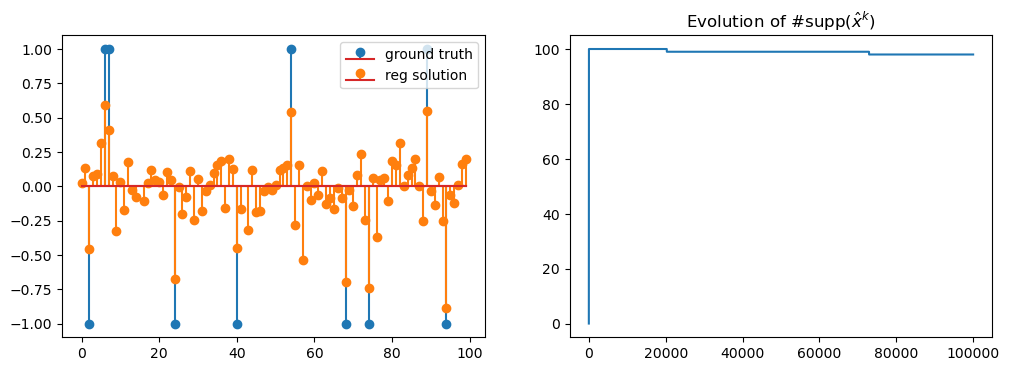

In [9]:
_=plt.figure(dpi=dpi, figsize=(12, 4))

_=plt.subplot(1, 2, 1)
sparse.stem(x0, "C0", "ground truth")
sparse.stem(x_noisy_penal, "C1", "reg solution")

_=plt.subplot(1, 2, 2)
_=plt.title(r"Evolution of #supp$(\hat{x}^k)$")
_=plt.plot(details_noisy_penal.get("iterate_sparsity"))
_=plt.show()

For small value of $\lambda$ the penalized problem is just too hard to solve. We could use more iterations or faster solver (inertia). But it doesn't seem to be the adapted method.


## 2. Algorithms

We compare CP and diagoFB on the exact problem and noisy one

In [10]:
# We solve the exact problem
y_hat = Phi@x0 + 0 * noisy_vector
iter_nb = 10**3
exp_decay = 0.1  # The smaller the exponent, the faster is the algorithm
reg_param_grid = 1 / (np.arange(iter_nb)+1)**exp_decay

x_sol_noisy, details_fb = fb_lasso(Phi, y_hat, reg_param_grid, iter_nb, verbose=True)

In [11]:
# We solve the exact problem with cp
y_hat = Phi@x0 + 0 * noisy_vector
iter_nb = 10**3
x_noisy_cp, details_cp = cp_lasso(Phi, y_hat, iter_nb, verbose=True)

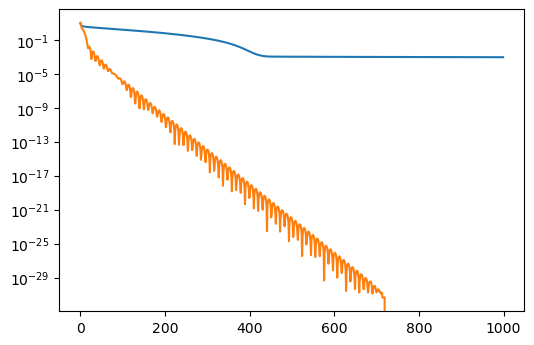

In [12]:
# Let's see who's faster, since we know the solution in the noiseless case
_=plt.figure(dpi=dpi)
plt.plot(np.sum(((details_fb.get("iterate_path") - x0)**2),axis=0))
plt.plot(np.sum(((details_cp.get("iterate_path") - x0)**2),axis=0))
plt.yscale('log')
plt.show()


We see that the CPC method converges linearly to the solution. So it should be the method of choice when studying the noisy problem. This being said for very noisy problems, slower algorithm are better (since we very early stop), so this might explain why sometimes DiagoFB provides better regularization. Slowing down CPC by playing with its stepsize might be worth it.

In [30]:
# We solve the noisy problem
y_hat = Phi@x0 + noise_level * noisy_vector
iter_nb = 10**4
exp_decay = 0.1  # The smaller the exponent, the faster is the algorithm
reg_param_grid = 1 / (np.arange(iter_nb)+1)**exp_decay

x_sol_noisy, details_fb = fb_lasso(Phi, y_hat, reg_param_grid, iter_nb, verbose=True)

In [31]:
# We solve the noisy problem with cp
y_hat = Phi@x0 + noise_level * noisy_vector
iter_nb = 10**4
x_noisy_cp, details_cp = cp_lasso(Phi, y_hat, iter_nb, stepsize_factor=1, verbose=True)

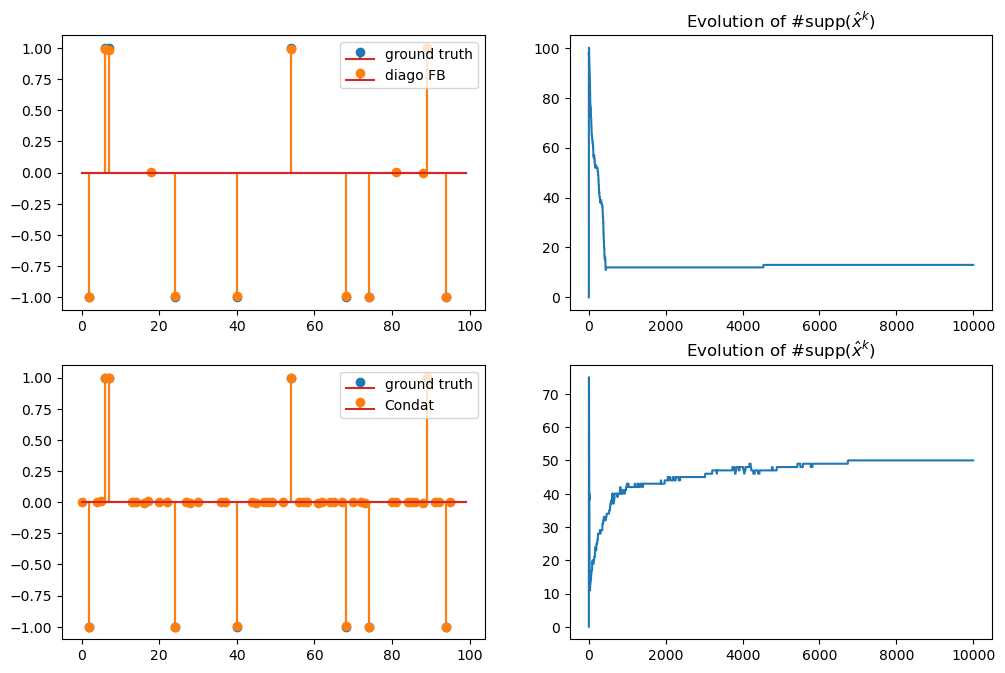

In [32]:
_=plt.figure(dpi=dpi, figsize=(12, 8))

_=plt.subplot(2, 2, 1)
sparse.stem(x0, "C0", "ground truth")
sparse.stem(x_sol_noisy, "C1", "diago FB")
_=plt.subplot(2, 2, 2)
_=plt.title(r"Evolution of #supp$(\hat{x}^k)$")
_=plt.plot(details_fb.get("iterate_sparsity"))

_=plt.subplot(2, 2, 3)
sparse.stem(x0, "C0", "ground truth")
sparse.stem(x_noisy_cp, "C1", "Condat")
_=plt.subplot(2, 2, 4)
_=plt.title(r"Evolution of #supp$(\hat{x}^k)$")
_=plt.plot(details_cp.get("iterate_sparsity"))

_=plt.show()

Some first conclusions here:
- Trying to solve the hierarchical problem with a penalization is complete crap. It requires to have very small regularization parameter, which mseems to make the optimization problem very slow to solve. Even $10^5$ aren't enough.
- Diagonal FB works decently, and does converge to the solution. Here I see that a decaying $\lambda_k \sim k^{-\alpha}$ works well with $\alpha = 0.1$. But theory says that $\alpha$ should be $1$? TBC
- Anyway the Chambolle-Pock-Condat works like a charm and should be preferred : it has constant parameters and **CRUSHES** the diagonal FB in terms of speed. I used default values.
- if we look at the support, it seems that diagonal FB has sparser solutions. But it is negligeable. I think it is due to the fact that DiagoFB is very slow (or maybe doesn't converge with this fast decaying sequence of parameters) and is therefore stuck in a regularization regime (we do not see yet overfitting). In other words, the exact solution is less sparse than DiagoFB suggests, it is just too slow to reach it.

To assert this last point, let's do again the experiments with a slower CPC:

In [47]:
# We solve the noisy problem with cp
y_hat = Phi@x0 + noise_level * noisy_vector
iter_nb = 4*10**4
x_noisy_cp, details_cp = cp_lasso(Phi, y_hat, iter_nb, stepsize_factor=0.01, verbose=True)

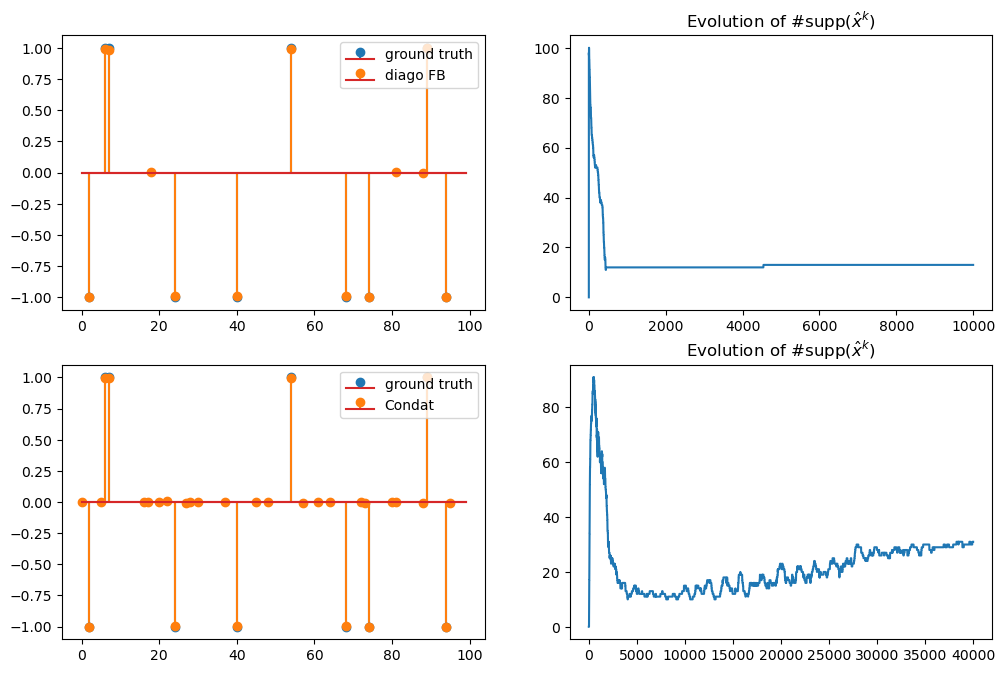

In [48]:
_=plt.figure(dpi=dpi, figsize=(12, 8))

_=plt.subplot(2, 2, 1)
sparse.stem(x0, "C0", "ground truth")
sparse.stem(x_sol_noisy, "C1", "diago FB")
_=plt.subplot(2, 2, 2)
_=plt.title(r"Evolution of #supp$(\hat{x}^k)$")
_=plt.plot(details_fb.get("iterate_sparsity"))

_=plt.subplot(2, 2, 3)
sparse.stem(x0, "C0", "ground truth")
sparse.stem(x_noisy_cp, "C1", "Condat")
_=plt.subplot(2, 2, 4)
_=plt.title(r"Evolution of #supp$(\hat{x}^k)$")
_=plt.plot(details_cp.get("iterate_sparsity"))

_=plt.show()

We see in that slower case that CPC passes through a similar kind of solution than DiagoFB. So CPC is really just faster, and goes faster to the less sparse solution.

In [72]:
# We put back the fast path
y_hat = Phi@x0 + noise_level * noisy_vector
iter_nb = 10**3
x_noisy_cp, details_cp = cp_lasso(Phi, y_hat, iter_nb, stepsize_factor=1, verbose=True)

In [73]:
def compute_reg_path(Phi, y, reg_param_grid):
    ''' Given a matrix Phi and (noisy) data y, returns the regularision
    path: we compute solutions $x_\lambda$ of each problem $(P_\lambda)$
    for $\lambda$ being taken in the list reg_param_grid
    '''
    reg_path = np.empty((Phi.shape[1], 0), int)
    x_ini = np.zeros((Phi.shape[1], 1))
    for reg_param in reg_param_grid:
        ''' We choose the number of iterations to do depending on the reg_param.
        This is a completely custom choice, it seems to work quite well
        in practice.
        '''
        if reg_param < 0.1:
            iter_nb = 60000
        elif reg_param < 1:
            iter_nb = 4000
        elif reg_param < 10:
            iter_nb = 1000
        else:
            iter_nb = 200
        # We use a warm restart approach:
        # for each problem we use the solution of the previous problem
        # as a starting point
        x_reg = fb_lasso(Phi, y, reg_param, iter_nb, x_ini=x_ini)
        x_ini = x_reg
        reg_path = np.concatenate((reg_path, x_reg), axis=1)
    return reg_path

In [74]:
def get_pca_projector(data):
    ''' Given a set of data points (stored in columns of a 2D np.array)
    returns the projection matrix corresponding to the 2 more relevant
    directions
    '''
    centered_points = data - np.mean(data, axis=1).reshape(data.shape[0], 1)
    V = np.cov(centered_points)
    _, vectors = la.eig(V)
    return np.real(vectors[:, 0:2]).T


def scatter_reg_path(path, limit=None, title=None):
    ''' Given a 2D path, plots it using scatter
    '''
    cm = plt.cm.get_cmap('RdBu')
    if limit is not None:
        plt.scatter(limit[0, :], limit[1, :], c='r', marker='x', s=150)
    if title is not None:
        _ = plt.title(title)
    plt.plot(path[0, :], path[1, :], c='black', linewidth=0.5)
    fig = plt.scatter(path[0, :], path[1, :], c=range(path.shape[1]),
                      vmin=0, vmax=path.shape[1], s=35, cmap=cm)
    plt.colorbar(fig)

In [75]:
reg_path_itreg = details_cp["iterate_path"]

In [76]:
def reg_param_selection(path, ground_truth):
    '''Given a regularization path and a ground truth,
    returns the best regularized solution (in L2 sense)
    '''
    path_length = path.shape[1]
    reg_sol = path[:, 0, None]
    reg_param_index = 0
    for k in np.arange(path_length):
        if la.norm(ground_truth - path[:, k, None]) \
                < la.norm(ground_truth - reg_sol):
            reg_sol = path[:, k, None]
            reg_param_index = k
    return reg_sol, reg_param_index

In [77]:
x_sol_itreg, best_param_itreg = reg_param_selection(reg_path_itreg, x0)
best_param_itreg

55

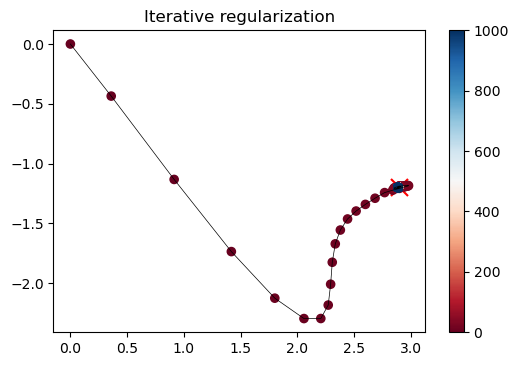

In [78]:
_=plt.figure(dpi=dpi)
P = get_pca_projector(reg_path_itreg)
scatter_reg_path(P@reg_path_itreg, title=f"Iterative regularization", limit=P@x0)

In [79]:
la.norm(x_sol_itreg - x0)

0.010150933435118128

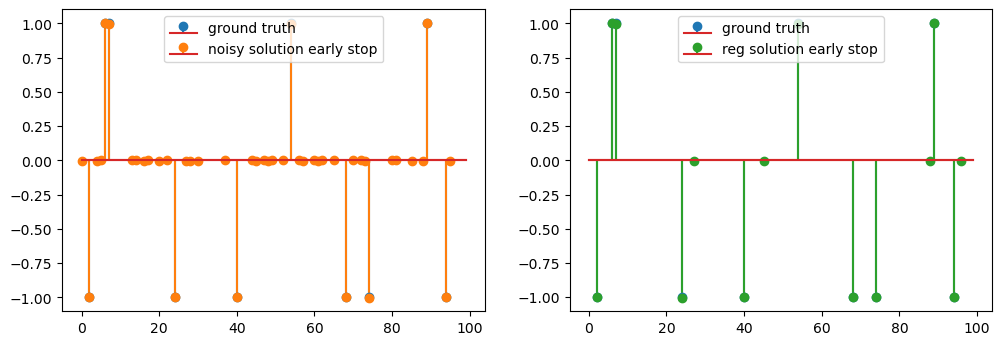

In [80]:
_=plt.figure(dpi=dpi, figsize=(12, 4))

_=plt.subplot(1, 2, 1)
sparse.stem(x0, "C0", "ground truth")
sparse.stem(x_noisy_cp, "C1", "noisy solution early stop")

_=plt.subplot(1, 2, 2)
sparse.stem(x0, "C0", "ground truth")
sparse.stem(x_sol_itreg, "C2", "reg solution early stop")

_=plt.show()

Here we see that from $\hat x^\dagger$ to $\hat x^t$ we have a slightly sparsest solution. What about the L2 distance?

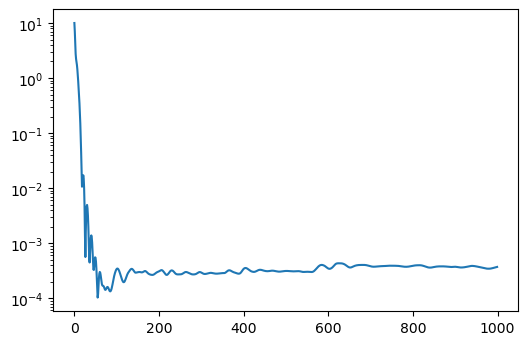

In [81]:
_=plt.figure(dpi=dpi)
plt.plot(np.sum(((reg_path_itreg - x0)**2),axis=0))
plt.yscale('log')
plt.show()

It is not *super* meaningful. 

Let's redo the experiments with a slower stepsize and more iterations, it should "zoom" the effect

In [83]:
x_noisy_cp, details_cp = cp_lasso(Phi, y_hat, iter_nb=10**5, stepsize_factor=0.1, verbose=True)
reg_path_itreg = details_cp["iterate_path"]
x_sol_itreg, best_param_itreg = reg_param_selection(reg_path_itreg, x0)

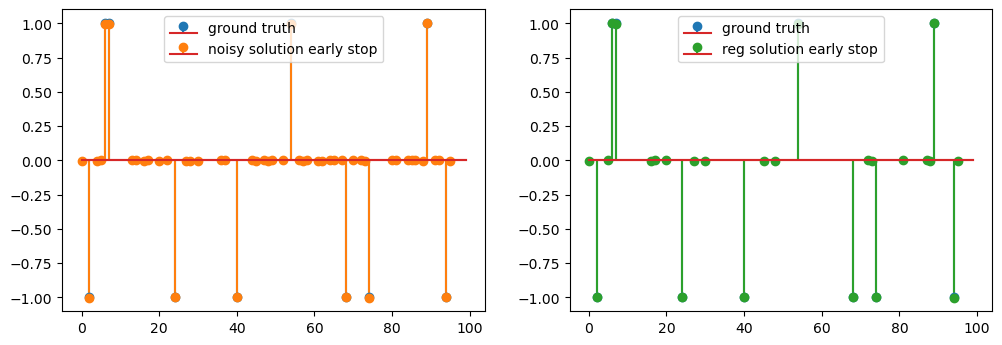

In [84]:
_=plt.figure(dpi=dpi, figsize=(12, 4))

_=plt.subplot(1, 2, 1)
sparse.stem(x0, "C0", "ground truth")
sparse.stem(x_noisy_cp, "C1", "noisy solution early stop")

_=plt.subplot(1, 2, 2)
sparse.stem(x0, "C0", "ground truth")
sparse.stem(x_sol_itreg, "C2", "reg solution early stop")

_=plt.show()

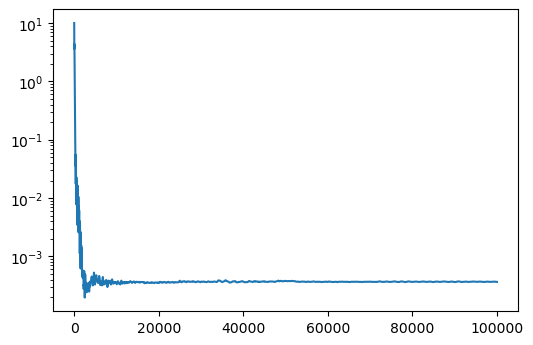

In [85]:
_=plt.figure(dpi=dpi)
plt.plot(np.sum(((reg_path_itreg - x0)**2),axis=0))
plt.yscale('log')
plt.show()

Yeah basically the same as before. I am a bit disappointed because I expected to see a nice bias/variance V-curve, but I guess that it is what it is. Also the noise regime might play a role. So far the noise level is $0.1$. For smaller noises I expect early stop to hold later, so maybe a "nicer" curve? Let's try that quickly.

In [86]:
y_hat = y + 0.001 * noisy_vector
x_noisy_cp, details_cp = cp_lasso(Phi, y_hat, iter_nb=10**5, stepsize_factor=0.1, verbose=True)
reg_path_itreg = details_cp["iterate_path"]
x_sol_itreg, best_param_itreg = reg_param_selection(reg_path_itreg, x0)

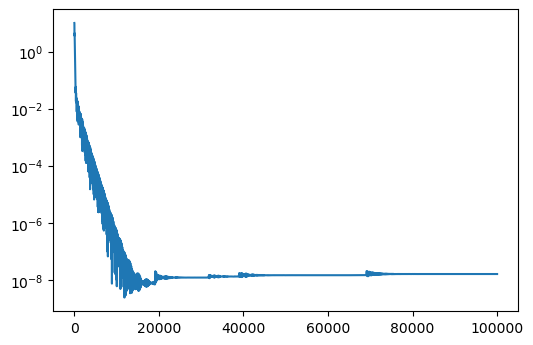

In [87]:
_=plt.figure(dpi=dpi)
plt.plot(np.sum(((reg_path_itreg - x0)**2),axis=0))
plt.yscale('log')
plt.show()

That's more or less the same. What about more noise?

In [98]:
y_hat = y + 5 * noisy_vector
x_noisy_cp, details_cp = cp_lasso(Phi, y_hat, iter_nb=10**5, stepsize_factor=0.01, verbose=True)
reg_path_itreg = details_cp["iterate_path"]
x_sol_itreg, best_param_itreg = reg_param_selection(reg_path_itreg, x0)

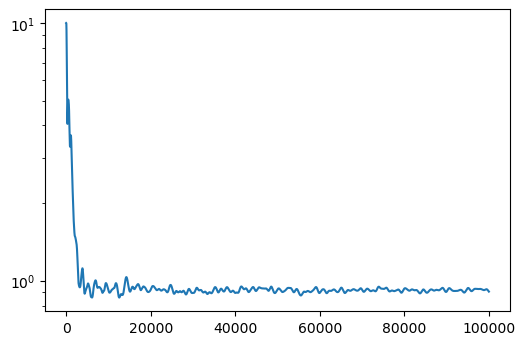

In [99]:
_=plt.figure(dpi=dpi)
plt.plot(np.sum(((reg_path_itreg - x0)**2),axis=0))
plt.yscale('log')
plt.show()

Nothing significantly different. Anyway we're in finite dimensions so the trajectory isn't going to diverge away!